In [ ]:
!pip install gymnasium

In [ ]:
###import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import numpy as np
import gymnasium as gym
import time
from gymnasium import spaces
import os
from matplotlib import pyplot as plt
from statistics import mean

## Grid world environment

In [ ]:
####################################### GRID WORLD ENV
# custom 2d grid world enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}

    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


    def __init__(self, width, height, reward_type="sparse", obstacles=False):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]
        self.num_actions = 4

        self.size = width * height  # size of the grid world
        self.num_states = self.size
        self.width = width
        self.height = height
        if obstacles:
            self.num_obstacles = int((width+height)/2)
        else:
            self.num_obstacles = 0
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8) # goal state = bottom right cell

        # actions of agents : up, down, left and right
        self.action_space = spaces.Discrete(4)
        # observation : cell indices in the grid
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])

        self.obstacles = np.zeros((height, width))

        for i in range(self.num_obstacles):
            self.obstacles[ random.randrange(height) , random.randrange(width)] = 1

        self.num_steps = 0
        self.max_steps = height*width

        self.current_state = np.zeros((2), np.uint8)#init state = [0,0]

        self.directions = np.array([
            [-1,0], #UP
            [0,-1], #LEFT
            [1,0], #DOWN
            [0,1] #RIGHT
        ])

        self.reward_type= reward_type

    def transition_function(self, s, a):
        s_prime =  np.zeros((2), np.uint8)
        s_prime = s + self.directions[a,:]

        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


    def reward_function(self,s):

        r = -1

        if self.reward_type == "sparse":
            if (s == self.end_state).all():
                r = 100
        else:
            r = 1 / (np.sum((self.end_state - s))+0.000001)

        return r

    def termination_condition(self, s):
        terminated = False
        truncated = False

        terminated = (s == self.end_state).all()
        truncated = self.num_steps > self.max_steps

        return terminated, truncated

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        terminated, truncated = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, terminated, truncated, None

    def render(self):
        '''
            render the state
        '''

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height):
            for c in range(self.width):
                if r == row and c == col:
                    print("| A ", end='')
                elif r == self.end_state[0] and c == self.end_state[1]:
                    print("| G ", end='')
                else:
                    if self.obstacles[r,c] == 1:
                        print('|///', end='')
                    else:
                        print('|___', end='')
            print('|')
        print('\n')



    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0

        return self.current_state

    def close(self):
        pass


class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8, reward_type="sparse", obstacles=False):
        super(NonDeterministicGridWorld, self).__init__(width, height, reward_type, obstacles)
        self.probability_right_action = p

    def transition_function(self, s, a):
        s_prime = s + self.directions[a, :]

        #with probability 1 - p diagonal movement
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                s_prime = s_prime + self.directions[(a+1)%self.num_actions, :]
            else:
                s_prime = s_prime + self.directions[(a-1)%self.num_actions, :]


        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


# Tile coding

In [ ]:
class TileCoding:
    def __init__(self, env):
        self.width = env.width
        self.height = env.height

    def __call__(self, s):
        # TODO 1: implement tile coding
        f = ...
        return f

    def _state_index(self, s):
        return int(s[0]) * self.width + int(s[1])

## n-step TD in V

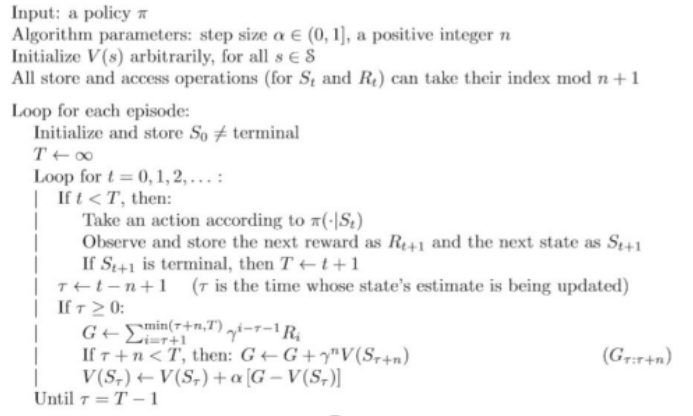

In [ ]:
def n_step_td(env, n=10, alpha=0.1, gamma=0.99, epsilon=0.5, n_episodes=10000, render=False):
    """
    Tabular n-step TD *prediction* for state-values V(s). Evaluates the given behavior policy.
    policy: "random" (default) — take actions uniformly at random.
    Returns the learned value table V of shape (height*width,).
    """
    assert n >= 1, "n must be >= 1"
    n_states = env.height * env.width
    V = np.zeros(n_states, dtype=float)
    ep_returns = []
    updates = []  # (ep, t, s_idx)

    tile_features = TileCoding(env)

    for ep in range(n_episodes):
        s = env.reset()
        states = [s]
        rewards = [0.0]  # r_0 placeholder
        T = float('inf')
        t = 0
        ep_return = 0.0

        while True:
            if t < T:
                # sample action according to random policy
                a = env.action_space.sample()
                s_next, r, terminated, truncated, info = env.step(a)
                if render:
                    env.render()
                rewards.append(r)
                states.append(s_next)
                ep_return += r

                if terminated or truncated:
                    # TODO 2: Update T
                    T = ...

            # TODO 3: Compute tau
            tau = ...

            if tau >= 0:
                # Compute n-step return for updating V(states[tau])
                G = 0.0
                if T == float('inf'):
                    upper = tau + n
                else:
                    upper = min(tau + n, int(T))
                for k in range(tau + 1, upper + 1):
                    # TODO 4: Update return
                    G += ...
                if tau + n < T:
                    # TODO 5
                    s_boot = ...
                    G += ...
                s_tau = states[tau]
                idx = tile_features._state_index(s_tau)
                # TODO 6: Update V
                V[idx] += ...
                updates.append((ep, t, idx))

            if tau == T - 1:
                break
            t += 1

        ep_returns.append(ep_return)

    return V, ep_returns, updates

In [ ]:
#define the env
env = NonDeterministicGridWorld(5,5, reward_type="sparse")

TD vs MC, RMSE = 5.428


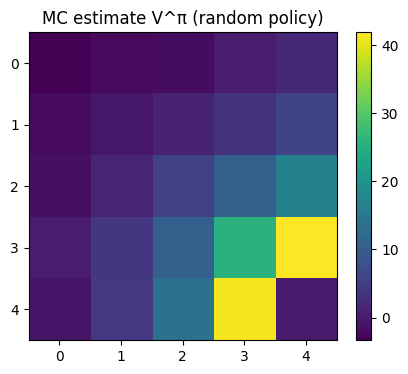

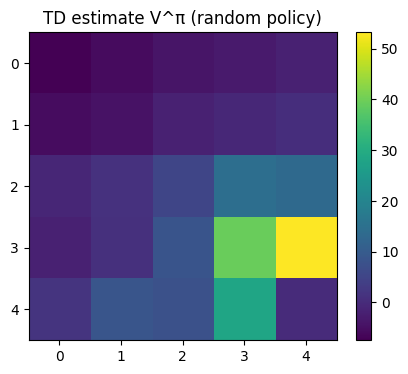

In [ ]:
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt

def mc_value_estimate(env, policy="random", episodes=5000, gamma=0.99):
    """Monte-Carlo estimate of V^π for the given policy (tabular)."""
    H, W = env.height, env.width
    n_states = H*W
    returns_sum = np.zeros(n_states, dtype=float)
    counts = np.zeros(n_states, dtype=float)
    V = np.zeros(n_states, dtype=float)
    tile_features = TileCoding(env)

    for _ in range(episodes):
        s = env.reset()
        done = False
        traj = []
        while not done:
            if policy == "random":
                a = env.action_space.sample()
            else:
                a = env.action_space.sample()
            s_next, r, terminated, truncated, _ = env.step(a)
            traj.append((s, r))
            s = s_next
            done = terminated or truncated

        # MC return from each first visit
        G = 0.0
        visited = set()
        for (st, r) in reversed(traj):
            G = r + gamma * G
            idx = tile_features._state_index(st)
            if idx not in visited:
                returns_sum[idx] += G
                counts[idx] += 1.0
                visited.add(idx)

    nonzero = counts > 0
    V[nonzero] = returns_sum[nonzero] / counts[nonzero]
    return V

def rmse(a, b):
    mask = np.isfinite(a) & np.isfinite(b)
    return np.sqrt(np.mean((a[mask] - b[mask])**2))

# 1) Monte-Carlo baseline for the *random* policy used in TD
V_mc = mc_value_estimate(env, policy="random", episodes=3000, gamma=0.99)

# 2) Re-run TD and track RMSE to the MC baseline as "learning"
V_td, td_returns, td_updates = n_step_td(
    env, n=3, alpha=0.1, gamma=0.99, n_episodes=1000
)

# 3) RMSE curve: lower is better
r = rmse(V_td, V_mc)
print(f"TD vs MC, RMSE = {r:.3f}")

def plot_value_grid(V, env, title="V(s)"):
    H, W = env.height, env.width
    grid = V.reshape(H, W)
    plt.figure(figsize=(5, 4))
    plt.imshow(grid, origin="upper")
    plt.colorbar()
    plt.title(title)
    plt.xticks(range(W))
    plt.yticks(range(H))
    plt.show()

# Optional: visualize both value maps
plot_value_grid(V_mc, env, title="MC estimate V^π (random policy)")
plot_value_grid(V_td, env, title="TD estimate V^π (random policy)")


## n-step SARSA
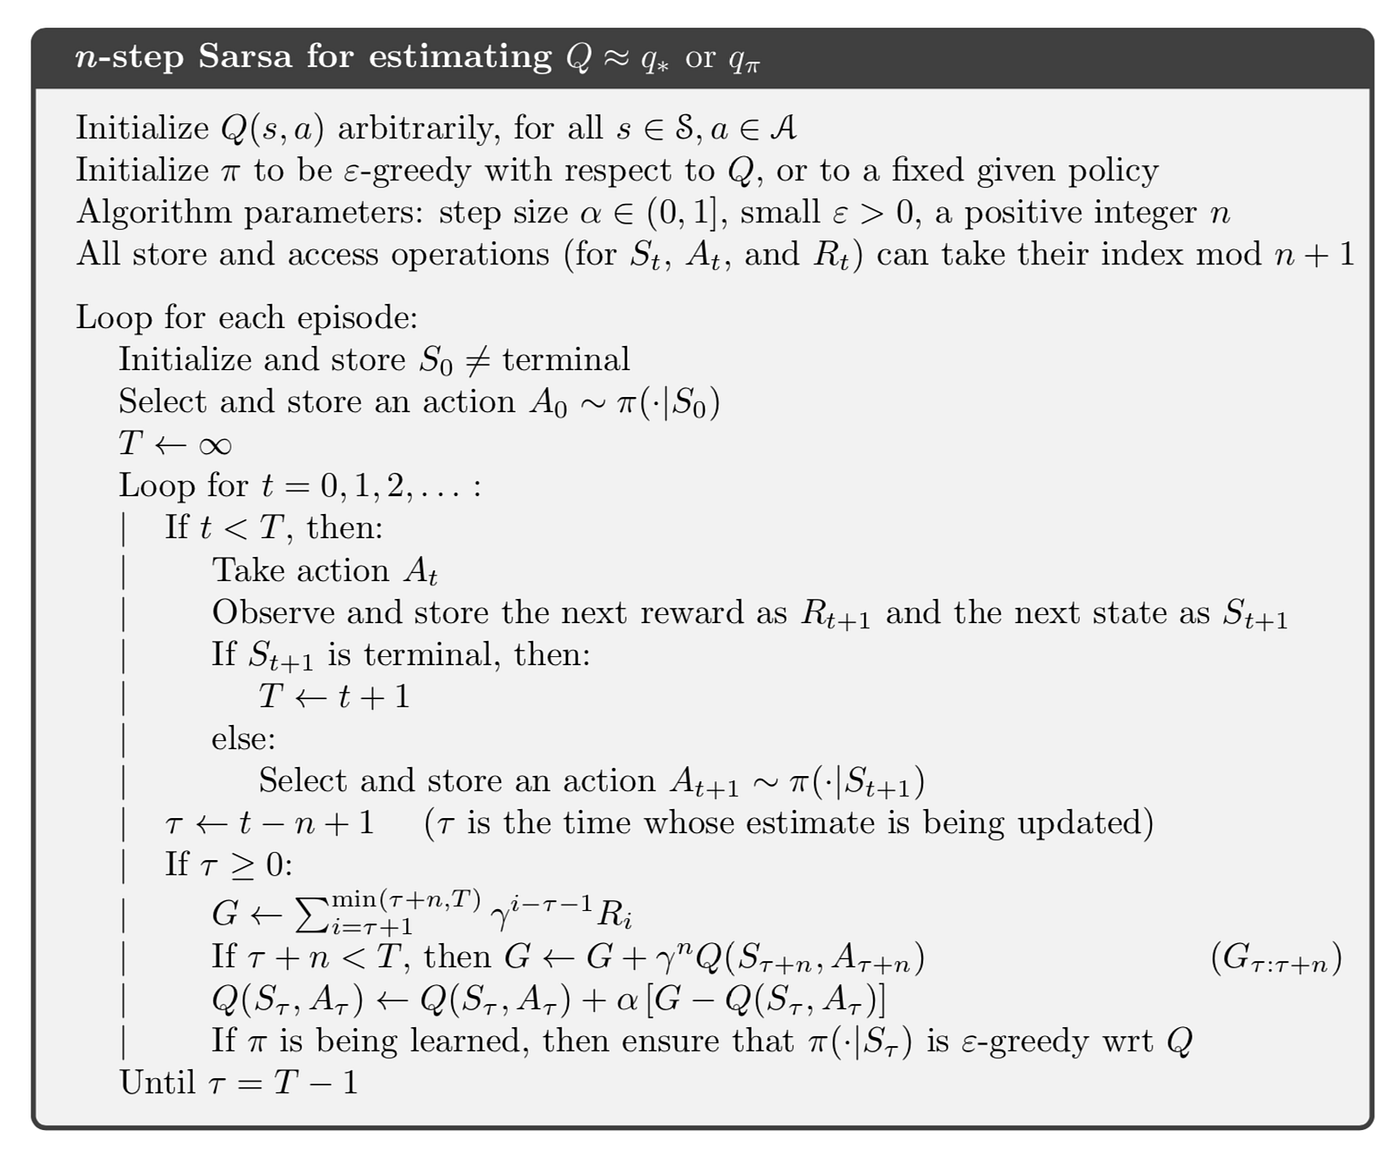

In [ ]:
def _eps_greedy_from_Q(env, Q, state, eps):
    tile_features = TileCoding(env)
    if random.random() < eps:
        return env.action_space.sample()
    idx = tile_features._state_index(state)
    return int(np.argmax(Q[idx]))

def evaluate_greedy_policy(env, Q, n_episodes=10):
    """Roll out the greedy policy from Q and return mean episode return."""
    rews = []
    for _ in range(n_episodes):
        s = env.reset()
        done = False
        G = 0.0
        while not done:
            a = _eps_greedy_from_Q(env, Q, s, eps=0.0)
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G += r
        rews.append(G)
    return float(mean(rews)) if rews else 0.0

def n_step_sarsa(env, n=10, alpha=1.0, gamma=0.99, initial_epsilon=1.0, eps_decay=0.9995, eps_min=0.05,
                 n_episodes=10000, eval_every=100, eval_episodes=20, render=False):
    """
    Tabular n-step SARSA (on-policy) control.
    Returns the learned Q-table of shape (height*width, num_actions).
    """
    assert n >= 1, "n must be >= 1"
    n_states = env.height * env.width
    n_actions = env.num_actions
    Q = np.zeros((n_states, n_actions), dtype=float)
    ep_returns = []
    eval_points = []
    eval_scores = []

    tile_features = TileCoding(env)

    epsilon = initial_epsilon

    for ep in range(n_episodes):
        s = env.reset()
        a = None

        # epsilon-greedy action
        if random.random() < epsilon:
            a = env.action_space.sample()
        else:
          idx = tile_features._state_index(s)
          a = np.argmax(Q[idx])

        states = [s]
        actions = [a]
        rewards = [0.0]
        T = float('inf')
        t = 0
        ep_return = 0.0

        while True:
            if t < T:
                s_next, r, terminated, truncated, info = env.step(actions[t])
                rewards.append(r)
                states.append(s_next)
                ep_return += r
                if render:
                    env.render()

                if terminated or truncated:
                    # TODO 7: Update T
                    T = ...
                else:
                    # epsilon-greedy action
                    if random.random() < epsilon:
                        a_next = env.action_space.sample()
                    else:
                      idx = tile_features._state_index(s_next)
                      a_next = np.argmax(Q[idx])
                    actions.append(a_next)

            # TODO 8: Compute tau
            tau = ...
            if tau >= 0:
                # Compute n-step SARSA target for (s_tau, a_tau)
                G = 0.0
                if T == float('inf'):
                    upper = tau + n
                else:
                    upper = min(tau + n, int(T))
                for k in range(tau + 1, upper + 1):
                  # TODO 9: Update return
                    G += ...

                if tau + n < T:
                    # TODO 10
                    s_boot = ...
                    a_boot = ...
                    G += ...

                s_tau = states[tau]
                a_tau = actions[tau]
                idx_tau = tile_features._state_index(s_tau)
                # TODO 11 Update Q
                td_error = ...
                Q[idx_tau, a_tau] += ...

            if tau == T - 1:
                break
            t += 1

        ep_returns.append(ep_return)

        # simple epsilon decay
        epsilon = max(eps_min, eps_decay * epsilon)

        if ep % eval_every == 0:
            score = evaluate_greedy_policy(env, Q, n_episodes=eval_episodes)
            eval_points.append(ep)
            eval_scores.append(score)

    return Q, ep_returns, (eval_points, eval_scores)


In [ ]:
#define the env
env = NonDeterministicGridWorld(5,5, reward_type="sparse")

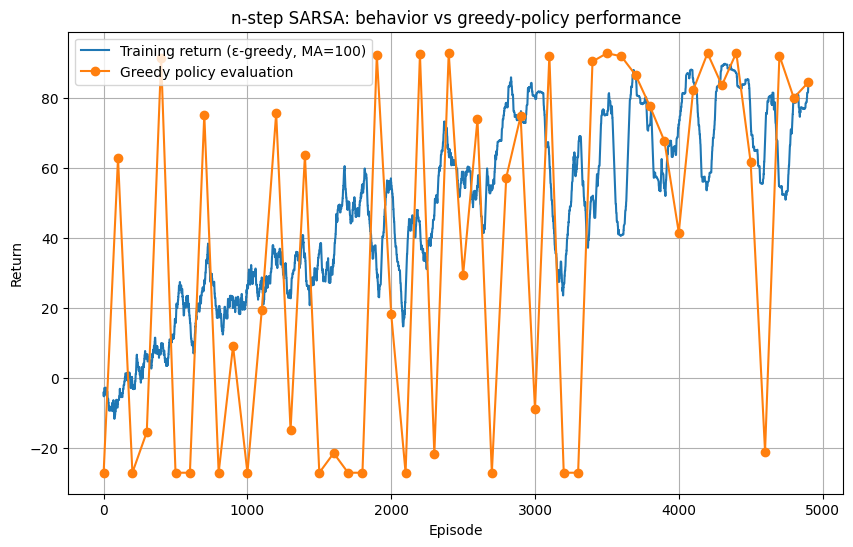

In [ ]:
# Train & plot
Q_sarsa, train_rets, (eval_x, eval_y) = n_step_sarsa(
    env, n=3, alpha=0.5, gamma=0.99,
    initial_epsilon=1.0, n_episodes=5000, eval_every=100, eval_episodes=20
)


def moving_average(x, window=50):
    if window <= 1 or window > len(x):
        return np.asarray(x, dtype=float)
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(np.asarray(x, dtype=float), kernel, mode="valid")

# Smoothed training returns (behavior), plus greedy eval curve
plt.figure(figsize=(10,6))
plt.plot(moving_average(train_rets, window=100), label="Training return (ε-greedy, MA=100)")
plt.plot(eval_x, eval_y, marker="o", linestyle="-", label="Greedy policy evaluation")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("n-step SARSA: behavior vs greedy-policy performance")
plt.grid(True)
plt.legend()
plt.show()

# Q learning with linear value function approximation (LVFA)

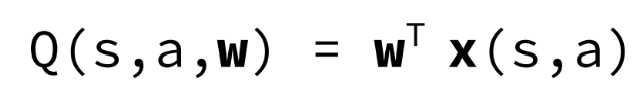

## Q function evluation

In [ ]:
def evaluate_q_lvfa(env, weights, n_episodes=10, render=False):
    tile_features = TileCoding(env)
    cum_rews = []
    for ep in range(n_episodes):
        if render:
            print("################## Episode ",ep+1)
        cum_rew = 0
        done = False
        state = env.reset()
        while not done:
            # TODO 12 choose greedy action
            # remember: weights have shape (n_actions, n_features)
            action = ...
            ############## simulate the action
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if render:
                print(env.ACTION_NAMES[action])
                env.render()
                print(done)
            cum_rew += reward
        cum_rews.append(cum_rew)
    mean_rew = mean(cum_rews)
    if render:
        print("Mean reward obtained in {} episodes: {} ".format( n_episodes, mean_rew))
    return mean_rew

## Q learning

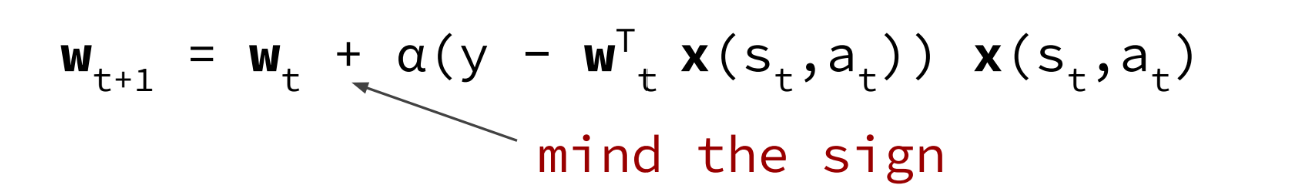

In [ ]:
def q_learning(env, alpha=1.0, gamma=0.99, initial_epsilon=1.0, n_episodes=10000):
    ####### Hyperparameters
    # alpha = learning rate
    # gamma = discount factor
    # initial_epsilon = initial epsilon value
    # n_episodes = number of episodes

    tile_features = TileCoding(env)

    # Initialize weights randomly
    n_actions = env.num_actions
    n_features = env.height*env.width
    weights = np.random.random((n_actions, n_features))

    # init epsilon
    epsilon = initial_epsilon

    received_first_reward = False

    #evaluation
    evaluation_rewards = []
    mean_evaluation_rewards = []
    window = 100

    for ep in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            if random.random() < epsilon:
                #print("exploration")
                action = env.action_space.sample() # Explore action space
            else:
                #print("exploitation")
                # TODO 13 choose greedy action
                action = ...

            ############## simulate the action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            #env.render()

            # TODO 14 update weights
            y = ...
            weights[action] += ...

            if not received_first_reward and reward > 0:
                received_first_reward = True
                print("Received first reward at episode ", ep)
            #update current state
            state = next_state

        #update current epsilon
        if received_first_reward:
            epsilon= 0.9999*epsilon

        #evaluate policy
        evaluation_rewards.append( evaluate_q_lvfa(env, weights, n_episodes=5) )
        mean_evaluation_rewards.append(mean(evaluation_rewards[-window: ]))


    plt.plot(mean_evaluation_rewards)

    print("Training finished in {} episodes\n".format(n_episodes))
    return weights


## test

In [ ]:
#define the env
env = NonDeterministicGridWorld(5,5, reward_type="sparse")

Received first reward at episode  1
Training finished in 100 episodes



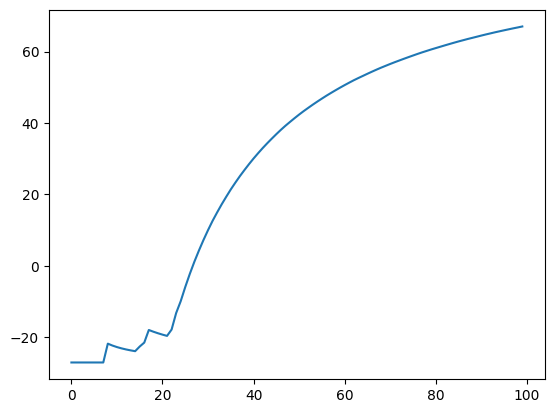

In [ ]:
## Q learning
weights = q_learning(env, alpha=0.2, initial_epsilon=0.8, n_episodes=100)


## Evaluate policy

## Render the agent behaviour

In [ ]:
mean_cum_rew = evaluate_q_lvfa(env, weights, render=True)

################## Episode  1
DOWN
|___|___|___|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___| A |___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___| A |___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___| A |___|
|___|___|___|___|___|
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___| A |___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| A |
|___|___|__